# 1. 神经网络结构设计与调优

在人工构造的 MNIST 数据集的子集上进行训练/测试，要求：

（1）参考课件中给出的代码，实现以下两种不同的网络结构（要求用 numpy 手动实现前向传播和反向传播等过程）：

- 2 层前馈网络，激活函数 sigmoid 或 tanh，隐含层维度自定
- 3 层前馈网络，激活函数 relu，隐含层维度自定

（2）两个网络在测试集上分类准确率均 $\ge$ 85%

（3）画出训练过程中训练集上 loss 和训练集上 accuracy 的变化曲线

本次作业可能涉及到的激活函数的定义及其导函数：

- $sigmoid(x)=1/(1+e^{-x})$, 导函数$sigmoid(x)(1-sigmoid(x))$
- $tanh(x)=(e^x-e^{-x})/(e^x+e^{-x})$，导函数$1-tanh^2(x)$
- $relu(x)=max(0,x)$，导函数$f(x)=\begin{cases}1, x>0 \\ 0, x\le0\end{cases}$

（附加）调优上一步实现的网络：

- batch size，iteration
- loss function（MSE，交叉熵……）
- 优化器的参数（学习率，学习率调整策略，优化器类型……）
- 网络权重初始化策略
- 数据预处理/增强

<font color=ff0000> ⚠️ 截止日期 5.16 中午 11:59，如果做了附加题调优，请在作业中注释出调优部分。⚠️</font>


In [1]:
# 读取训练和测试数据
# 本次作业为加快训练速度，只取1000个样本作为训练集，200个样本作为测试集
# 每个样本原本是28*28的图片，reshape成784维向量输入神经网络
# 只取（形状比较相近的）数字8和数字9两个类，做二分类，并将数字8的label重新标为0，数字9的label重新标为1
# 两个类的训练样本数不均衡（1:3）
# 本部分代码不可修改

import numpy as np

np.random.seed(0)

f = np.load("./mnist.npz")
x_train, y_train = f["x_train"], f["y_train"]
x_test, y_test = f["x_test"], f["y_test"]


def get_small_data(x_data, y_data, num1, num2):
    cnt1, cnt2, final_x, final_y = 0, 0, [], []
    for i in range(x_data.shape[0]):
        x = x_data[i, :].reshape(-1).tolist()
        y = y_data[i]
        if y == 8 and cnt1 < num1:
            final_x.append(x)
            final_y.append(0)
            cnt1 += 1
        elif y == 9 and cnt2 < num2:
            final_x.append(x)
            final_y.append(1)
            cnt2 += 1
    return np.array(final_x), np.array(final_y)


x_train, y_train = get_small_data(x_train, y_train, num1=250, num2=750)
x_test, y_test = get_small_data(x_test, y_test, num1=100, num2=100)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(1000, 784)
(1000,)
(200, 784)
(200,)


In [2]:
from abc import abstractmethod

###############################################################################
# Utils
###############################################################################


###############################################################################
# NN & operations
###############################################################################


class Layer:
    """
    Abstract class for nn operations
    """

    @abstractmethod
    def forward(self, x: np.ndarray, *args, **kwargs):
        ...

    @abstractmethod
    def backward(self, grad_output: np.ndarray):
        ...

    @abstractmethod
    def update(self, lr: float):
        ...

    def __call__(self, x: np.ndarray, *args, **kwargs):
        return self.forward(x, *args, **kwargs)


class Linear(Layer):
    def __init__(
        self,
        in_num: int,
        out_num: int,
        bias=True,
        init_std: float = 0.5,
        dtype=np.float64,
    ):
        """
        W: (out_num, in_num)
        b: (out_num, 1)
        """
        self.in_num = in_num
        self.out_num = out_num
        self.bias = True
        # Initialize weights with normal distribution
        self.W = np.random.normal(scale=init_std, size=(out_num, in_num)).astype(dtype)
        self.b = (
            np.random.normal(scale=init_std, size=(out_num,)).astype(dtype)
            if self.bias
            else 0
        )
        self.grad_W = None
        if self.bias:
            self.grad_b = None
        self.x = None

    def forward(self, x: np.ndarray, *args, **kwargs):
        """
        x: (batch_size, in_num)
        """
        self.x = x
        return ((self.W @ x.T).T + self.b) if self.bias else (self.W @ x.T).T

    def backward(self, grad_output: np.ndarray):
        """
        grad_output: (batch_size, out_num)
        """
        assert self.x is not None, "must call `forward()` before `backward()`"
        self.grad_W = grad_output.T @ self.x
        if self.bias:
            self.grad_b = np.sum(grad_output, axis=0)
        return grad_output @ self.W

    def update(self, lr: float):
        assert (
            self.grad_W is not None and self.grad_b is not None
        ), "must call `backward()` before `update()`"
        self.W -= lr * self.grad_W
        if self.bias:
            self.b -= lr * self.grad_b
        # reset gradient
        self.grad_W = None
        self.grad_b = None
        # reset cache
        self.x = None

    def __repr__(self):
        return f"Linear(in_num={self.in_num}, out_num={self.out_num}, bias={self.bias})"


class ReLu(Layer):
    def __init__(self):
        self.x = None

    def forward(self, x: np.ndarray, *args, **kwargs):
        self.x = x
        return np.maximum(0, x)

    def backward(self, grad_output: np.ndarray):
        assert self.x is not None, "must call `forward()` before `backward()`"
        return (self.x > 0) * grad_output

    def update(self, lr):
        # reset cache
        self.x = None

    def __repr__(self):
        return "ReLu()"


class Sigmoid(Layer):
    def __init__(self):
        self.x = None

    def forward(self, x: np.ndarray, *args, **kwargs):
        self.x = 1 / (1 + np.exp(-x))
        return self.x

    def backward(self, grad_output: np.ndarray):
        assert self.x is not None, "must call `forward()` before `backward()`"
        return (self.x - self.x**2) * grad_output

    def update(self, lr):
        # reset cache
        self.x = None

    def __repr__(self):
        return "Sigmoid()"


class Tanh(Layer):
    def __init__(self):
        self.x = None

    def forward(self, x: np.ndarray, *args, **kwargs):
        ex = np.exp(x)
        nex = np.exp(-x)
        self.x = (ex - nex) / (ex + nex)
        return self.x

    def backward(self, grad_output: np.ndarray):
        assert self.x is not None, "must call `forward()` before `backward()`"
        return (1 - self.x**2) * grad_output

    def update(self, lr):
        # reset cache
        self.x = None

    def __repr__(self):
        return "Tanh()"


class Sequential(Layer):
    def __init__(self, layers: list):
        self.layers = layers

    def forward(self, x: np.ndarray, *args, **kwargs):
        for layer in self.layers:
            x = layer(x)
        return x

    def backward(self, grad_output: np.ndarray):
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
        return grad_output

    def update(self, lr: float):
        for layer in self.layers:
            layer.update(lr)

    def __repr__(self):
        return (
            "Sequential(\n\t" + "\n\t".join([l.__repr__() for l in self.layers]) + "\n)"
        )


In [3]:
###############################################################################
# Loss function
###############################################################################


class CrossEntropy(Layer):
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x: np.ndarray, y: np.ndarray, *args, **kwargs):
        """
        x: (batch_size, num_classes)
        y: (batch_size, 1)
        """
        x = np.clip(x, a_min=1e-15, a_max=None)
        self.x = np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)
        self.y = np.zeros_like(x)
        self.y[np.arange(x.shape[0]), y] = 1
        return -np.sum(np.where(self.y, np.log(self.x), 0)) / x.shape[0]

    def backward(self, grad_output=None):
        assert (
            self.x is not None and self.y is not None
        ), "must call `forward()` before `backward()`"
        return self.x - self.y

    def update(self, lr):
        # reset cache
        self.x = None
        self.y = None


In [4]:
###############################################################################
# Optimizer & scheduler
###############################################################################


class Optimizer:
    def __init__(self, lr: float):
        self.lr = lr

    @abstractmethod
    def step(self):
        ...


class SGD(Optimizer):
    def step(self, model: Layer):
        model.update(self.lr)


class Scheduler:
    def __init__(self, optimizer: Optimizer):
        self.target = optimizer

    @abstractmethod
    def step(self):
        ...


class StepLR(Scheduler):
    def __init__(self, optimizer: Optimizer, steps, lr):
        super().__init__(optimizer)
        assert len(steps) == len(
            lr
        ), "Steps and learning rates should be of same length"
        self.steps = steps
        self.lr = lr
        self.counter = 0

    def step(self):
        self.counter += 1
        for step, lr in zip(self.steps, self.lr):
            if self.counter > step:
                continue
            self.target.lr = lr
            break


class ExponentialLR(Scheduler):
    def __init__(self, optimizer: Optimizer, gamma=0.99):
        super().__init__(optimizer)
        self.gamma = gamma

    def step(self):
        self.target.lr *= self.gamma


In [5]:
###############################################################################
# Dataset & dataloader
###############################################################################


class Transform:
    """
    Apply transformation for data augmentation
    """

    @abstractmethod
    def __call__(self, x: np.ndarray):
        ...


class TF_ToFloat64(Transform):
    """
    Convert datatype to float64
    """

    def __call__(self, x: np.ndarray):
        return x.astype(np.float64)


class TF_GaussianNoise(Transform):
    """
    Add standard gaussian noise to data
    """

    def __init__(self, mean=None, std=None):
        self.mean = mean if mean is not None else 0
        self.std = std if std is not None else 1

    def __call__(self, x: np.ndarray):
        return x + np.random.normal(size=x.shape)


class TF_Normalize(Transform):
    """
    Rescale data to standard normal distribution
    """

    def __init__(self, mean=None, std=None):
        self.mean = (lambda _: mean) if mean is not None else np.mean
        self.std = (lambda _: std) if std is not None else np.std

    def __call__(self, x: np.ndarray):
        return (x - self.mean(x)) / self.std(x)


class TF_Sequential(Transform):
    """
    Combines different transformations sequentially
    """

    def __init__(self, *tfs):
        self.tfs = tfs

    def __call__(self, x: np.ndarray):
        for tf in self.tfs:
            x = tf(x)
        return x


class Dataset:
    def __init__(self, X, Y, init_transform=None, transform=None):
        assert (
            X.shape[0] == Y.shape[0]
        ), "X and Y must be batch first and have same length"
        self.input_data = init_transform(X) if init_transform is not None else X
        self.output_data = Y
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return (
            self.input_data[idx, ...]
            if self.transform is None
            else self.transform(self.input_data[idx, ...]),
            self.output_data[idx, ...],
        )


class DataLoader:
    def __init__(self, dataset: Dataset, batch_size: int, shuffle: bool = True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __iter__(self):
        if self.shuffle:
            self.batch_idx = np.random.permutation(len(self.dataset))
            return (
                self.dataset[self.batch_idx[i : i + self.batch_size]]
                for i in range(0, len(self.dataset), self.batch_size)
            )
        else:
            return (
                self.dataset[i : i + self.batch_size]
                for i in range(0, len(self.dataset), self.batch_size)
            )


In [6]:
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 10
num_epochs = 25
print_interval = 5
init_tf = TF_Sequential(
    TF_ToFloat64(),
    TF_Normalize(),
)
trainset = Dataset(
    x_train, y_train, init_transform=init_tf, transform=TF_GaussianNoise(0, 1 / 2)
)
testset = Dataset(x_test, y_test, init_transform=init_tf)
trainloader = DataLoader(trainset, batch_size)
testloader = DataLoader(testset, batch_size, shuffle=False)


Sequential(
	Linear(in_num=784, out_num=128, bias=True)
	Tanh()
	Linear(in_num=128, out_num=2, bias=True)
)
epoch [5/25], accuracy 87.9%
epoch [10/25], accuracy 92.2%
epoch [15/25], accuracy 93.0%
epoch [20/25], accuracy 93.6%
epoch [25/25], accuracy 94.5%
accuracy on test dataset 89.0%


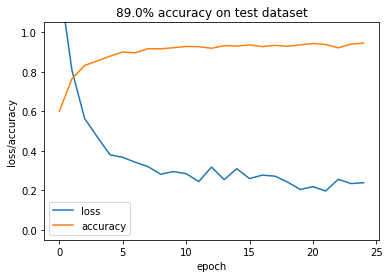

In [7]:
# TODO
# 2层前馈网络，以sigmoid或tanh作为激活函数
model = Sequential(
    [
        Linear(784, 128),
        Tanh(),
        Linear(128, 2),
    ]
)
print(model)
optimizer = SGD(lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.95)
loss = CrossEntropy()
loss_history = []
acc_history = []
for epoch in range(num_epochs):
    correct = 0
    loss_history.append(0)
    for images, labels in trainloader:
        output = model(images)
        correct += np.sum(np.argmax(output, axis=-1) == labels)
        loss_value = loss(output, labels)
        loss_history[-1] += loss_value * images.shape[0]
        model.backward(loss.backward())
        optimizer.step(model)
    loss_history[-1] /= len(trainset)
    acc_history.append(correct / len(trainset))
    if (epoch + 1) % print_interval == 0:
        print(f"epoch [{epoch+1}/{num_epochs}], accuracy {acc_history[-1]*100:.1f}%")
    scheduler.step()


# TODO
# 2层前馈网络test集上准确率
correct = 0
for images, labels in testloader:
    output = model(images)
    correct += np.sum(np.argmax(output, axis=-1) == labels)
print(f"accuracy on test dataset {correct / len(testset)*100:.1f}%")

plt.plot(loss_history, label="loss")
plt.plot(acc_history, label="accuracy")
plt.title(f"{correct / len(testset)*100:.1f}% accuracy on test dataset")
plt.xlabel("epoch")
plt.ylabel("loss/accuracy")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.show()


Sequential(
	Linear(in_num=784, out_num=128, bias=True)
	ReLu()
	Linear(in_num=128, out_num=18, bias=True)
	ReLu()
	Linear(in_num=18, out_num=2, bias=True)
)
epoch [5/25], accuracy 93.0%
epoch [10/25], accuracy 94.9%
epoch [15/25], accuracy 95.1%
epoch [20/25], accuracy 95.4%
epoch [25/25], accuracy 97.3%
accuracy on test dataset: 94.0%


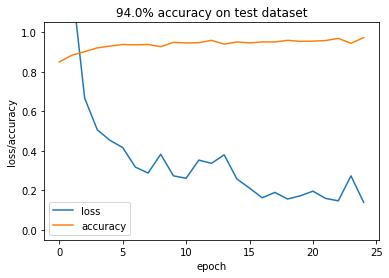

In [8]:
# TODO
# 3层前馈网络，以relu作为激活函数
model = Sequential(
    [
        Linear(784, 128),
        ReLu(),
        Linear(128, 18),
        ReLu(),
        Linear(18, 2),
    ]
)
print(model)
optimizer = SGD(lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.95)
loss = CrossEntropy()
loss_history = []
acc_history = []
for epoch in range(num_epochs):
    correct = 0
    loss_history.append(0)
    for images, labels in trainloader:
        output = model(images)
        correct += np.sum(np.argmax(output, axis=-1) == labels)
        loss_value = loss(output, labels)
        loss_history[-1] += loss_value * images.shape[0]
        model.backward(loss.backward())
        optimizer.step(model)
    loss_history[-1] /= len(trainset)
    acc_history.append(correct / len(trainset))
    if (epoch + 1) % print_interval == 0:
        print(f"epoch [{epoch+1}/{num_epochs}], accuracy {acc_history[-1]*100:.1f}%")
    scheduler.step()

# TODO
# 3层前馈网络test集上准确率
correct = 0
for images, labels in testloader:
    output = model(images)
    correct += np.sum(np.argmax(output, axis=-1) == labels)
print(f"accuracy on test dataset: {correct / len(testset)*100:.1f}%")

plt.plot(loss_history, label="loss")
plt.plot(acc_history, label="accuracy")
plt.title(f"{correct / len(testset)*100:.1f}% accuracy on test dataset")
plt.xlabel("epoch")
plt.ylabel("loss/accuracy")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.show()


- [x] Batch size
- [x] Cross entropy loss function
- [ ] MSE loss function (too lazy)
- [x] SGD optimizer
- [ ] SGD optimizer with momentum (too complicated to implement without reimplementing tensor)
- [ ] Adam optimizer (same reason as above)
- [x] Exponential learning rate
- [x] Step learning rate
- [x] Random normal initialization
- [x] Data normalization
- [x] Gaussian noise data augmentation
